In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import re
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
from glob import glob
from copy import deepcopy
from sklearn.metrics import auc, roc_auc_score, roc_curve
from scipy.stats import pearsonr, chi2_contingency, linregress, ranksums
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn3
import matplotlib as mpl
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib import font_manager

In [3]:
label_dict = {'Normal':0,'Tumor':1}

In [4]:
sns.set_style('ticks')

In [5]:
group_colors = [
    "#E53935", "#1E88E5", "#FFB300", "#43A047", "#9B26B0", "#3F51B4", "#02A9F3", "#00BBD3", "#009687", "#8BC34A",
    "#CCDC39", "#FFEB3A", "#FF9800", "#FF5721", "#795447", "#5F7D8B", "#E57272", "#F06192", "#B967C7", "#7985CB",
    "#4EC3F7", "#4CD0E0", "#4CB6AC", "#ADD480", "#DCE674", "#FFF176", "#FFB74C", "#FF8A65", "#A0877F", "#90A4AD",
    "#C52727", "#AC1357", "#6A1A99", "#273492", "#0177BD", "#00838E", "#00685B", "#548B2E", "#9E9D24", "#F8A725",
    "#EE6C00", "#D84314", "#4D332D", "#37464E", "#EE9999", "#F38EB1", "#CD92D8", "#9FA7D9", "#80D3F9", "#7FDEEA",
    "#7FCBC4", "#C5E0A5", "#E5ED9B", "#FFF49D", "#FFCC7F", "#FFAB91", "#BBAAA4", "#B0BEC5", "#FF6E00", "#202020",
    "#1A5E1F", "#311A92", "#FFC006", "#9E9E9E", "#4CAE50", "#6639B7", "#FFD44E", "#DFDFDF", "#80C684", "#9474CC",
    "#FF9F00", "#606060", "#388D3B", "#512CA7", "#FFDF81", "#EDEDED", "#A5D6A6", "#B29DDA", "#FFF8E0", "#F9F9F9"]

In [6]:
sc.settings.set_figure_params(figsize=(5,5), dpi=100, facecolor='white')

In [7]:
os.chdir('/mnt/home/qnyu/workspace/scOmics/malignantModel/multi_tissue')

In [ ]:
training_lung_adata = sc.read_h5ad('../lung/training.h5ad')
training_lung_adata.obs = pd.read_csv('./file/trainingLC.meta.tsv', index_col=0, sep='\t')
training_crc1_adata = sc.read_h5ad('/mnt/home/qnyu/workspace/scOmics/Dataset/CRC/PMID34910928_Cell_2021_colorectalPolyps/Discovery.epithelial.count.h5ad')
training_crc1_adata.obs = pd.read_csv('./file/trainingCRC1.meta.tsv', index_col=0, sep='\t')
training_crc2_adata = sc.read_h5ad('/mnt/home/qnyu/workspace/scOmics/Dataset/CRC/GSE132465_colorectal_2020/CRC.GSE132465.count.h5ad')
training_crc2_adata.obs = pd.read_csv('./file/trainingCRC2.meta.tsv', index_col=0, sep='\t')
training_gc_adata = sc.read_h5ad('/mnt/home/qnyu/workspace/scOmics/Dataset/GastricCancer/PMID36929873_CD_2023_EsophagealandGastricIntestinalMetaplasia/GC.epithelial.count.h5ad')
training_gc_adata.obs = pd.read_csv('./file/trainingGC.meta.tsv', index_col=0, sep='\t')
training_hcc_adata = sc.read_h5ad('/mnt/home/qnyu/workspace/scOmics/Dataset/HCC/GSE151530_2021_JofHepatol/HCC.GSE151530.epithelial.count.h5ad')
training_hcc_adata.obs = pd.read_csv('./file/trainingHCC.meta.tsv', index_col=0, sep='\t')

In [9]:
input_adata_dict = {}
input_adata_dict['Lung cancer (LuCA)'] = deepcopy(training_lung_adata)
input_adata_dict['Colorectal cancer (Chen et al.)'] = deepcopy(training_crc1_adata)
input_adata_dict['Colorectal cancer (Lee et al.)'] = deepcopy(training_crc2_adata)
input_adata_dict['Gastric cancer (Nowicki-Osuch et al.)'] = deepcopy(training_gc_adata)
input_adata_dict['Liver cancer (Ma et al.)'] = deepcopy(training_hcc_adata)

In [8]:
cancer_geneset_dict = {}
cancersea_geneset_dict = {}
pathway_geneset_dict = {}
ecotyper_geneset_dict = {}

with open('../../Public/signature/TumorCell_markers.gmt') as f:
    for line in f:
        data = line.strip().split('\t')
        cancer_geneset_dict[data[0]] = data[2:]
        
with open('../../Public/signature/cancerSEA_14functionalStates.gmt') as f:
    for line in f:
        data = line.strip().split('\t')
        cancersea_geneset_dict[data[0]] = data[2:]
        
with open('../../Public/signature/pathway_10hallmarks.gmt') as f:
    for line in f:
        data = line.strip().split('\t')
        pathway_geneset_dict[data[0]] = data[2:]
        
with open('../../Public/signature/EcoTyper_states.gmt') as f:
    for line in f:
        data = line.strip().split('\t')
        ecotyper_geneset_dict[data[0]] = data[2:]

In [8]:
order_genesets = list(cancer_geneset_dict.keys())+list(cancersea_geneset_dict.keys())+list(pathway_geneset_dict.keys())+list(ecotyper_geneset_dict.keys())

In [26]:
sc_score_logfc_df = pd.DataFrame(index=input_adata_dict.keys(), columns=order_genesets)
sc_score_logp_df = pd.DataFrame(index=input_adata_dict.keys(), columns=order_genesets)
for cancer in input_adata_dict.keys():
    sc_core_df = input_adata_dict[cancer].obs
    normal_samples = sc_core_df[sc_core_df['Raw_annotation']=='Normal'].index.tolist()
    tumor_samples = sc_core_df[sc_core_df['Raw_annotation']=='Tumor'].index.tolist()
        
    for geneset in order_genesets:
        geneset
        pval = ranksums(sc_core_df.loc[normal_samples,geneset],sc_core_df.loc[tumor_samples,geneset])[1]
        logfc = np.log2(sc_core_df.loc[tumor_samples,geneset].mean() / sc_core_df.loc[normal_samples,geneset].mean())
        sc_score_logfc_df.loc[cancer,geneset] = logfc
        sc_score_logp_df.loc[cancer,geneset] = -np.log10(pval) if pval!=0 else 300
sc_score_logfc_df= sc_score_logfc_df.applymap(float)
sc_score_logp_df = sc_score_logp_df.applymap(int)
sc_score_logp_df[sc_score_logp_df>300] = 300

for cancer in sc_score_logp_df.index:
    for geneset in sc_score_logp_df.columns:
        if sc_score_logp_df.loc[cancer,geneset] <= 10:
            sc_score_logfc_df.loc[cancer,geneset] = np.nan

sc_score_logfc_df = sc_score_logfc_df.T
sc_score_logp_df = sc_score_logp_df.T

/tmp/ipykernel_1193/2182088522.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sc_score_logfc_df= sc_score_logfc_df.applymap(float)
/tmp/ipykernel_1193/2182088522.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sc_score_logp_df = sc_score_logp_df.applymap(int)


In [27]:
sc_score_logfc_df.columns = sc_score_logfc_df.columns.map(lambda x: x.replace(' (','\n('))

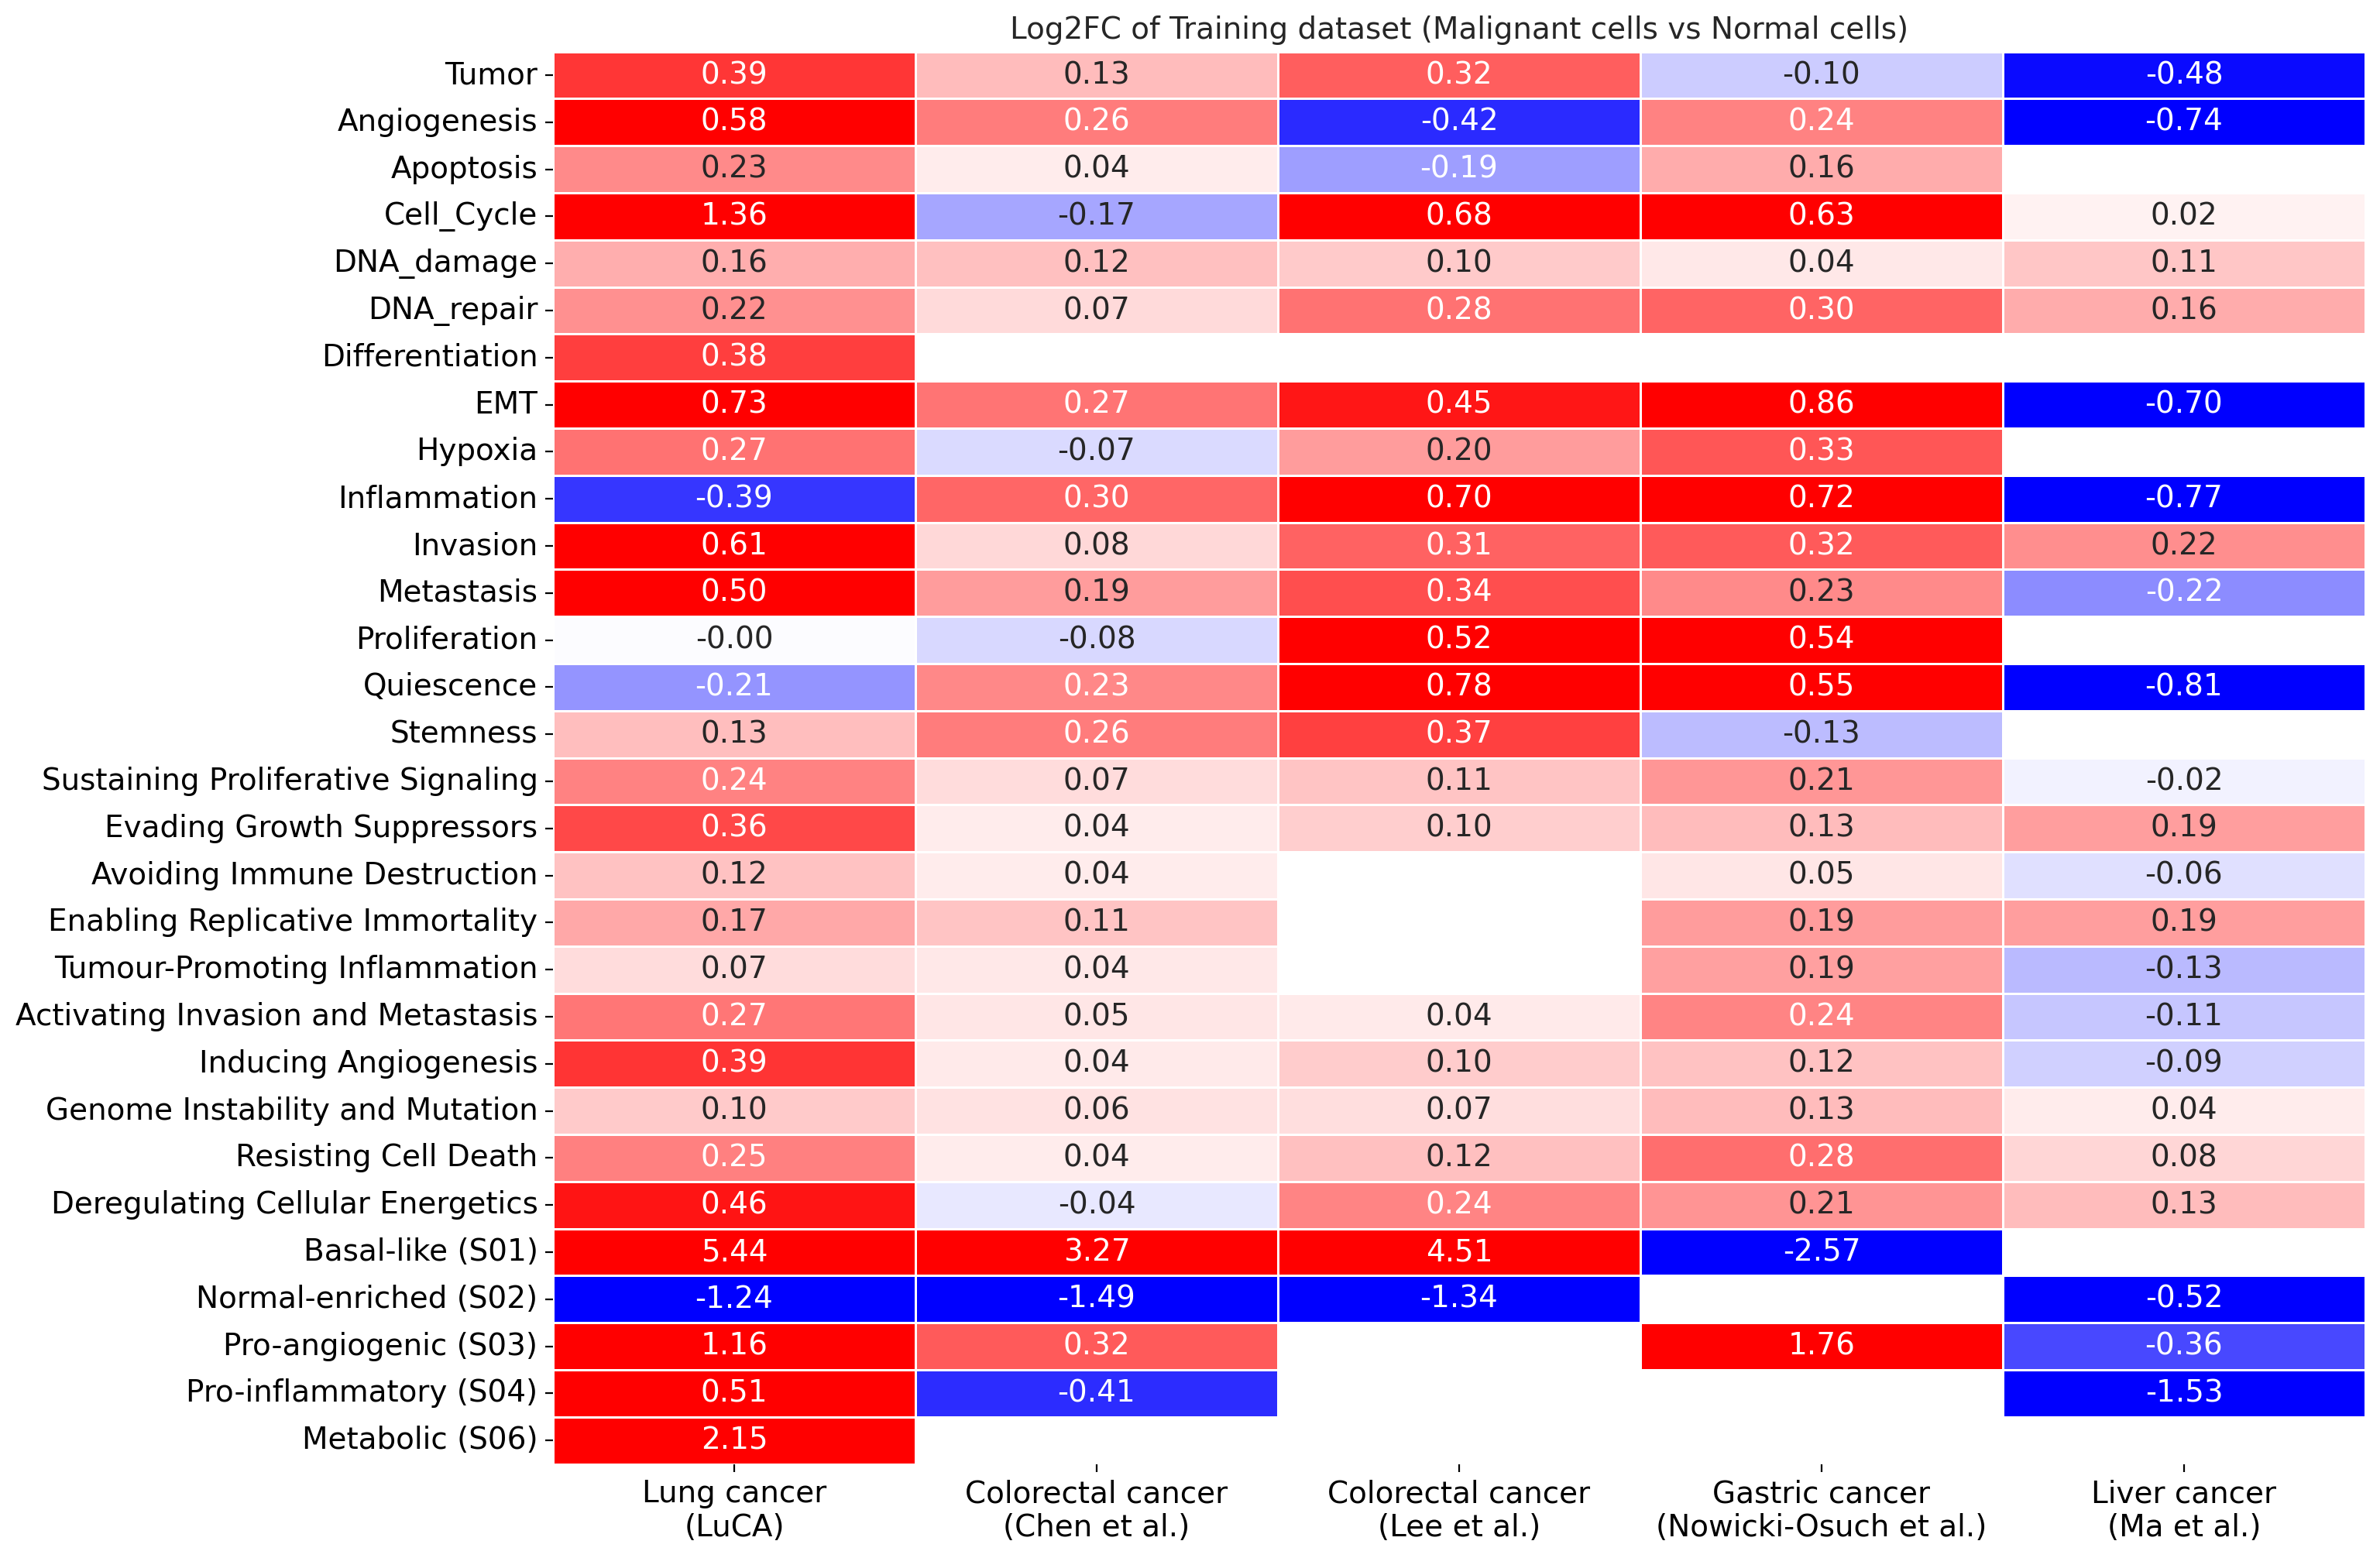

In [32]:
plt.figure(figsize=(15,12))
ax21 = plt.subplot(111)
sns.heatmap(sc_score_logfc_df, annot=True, fmt='.2f', cmap='bwr', yticklabels=True, cbar=False, ax=ax21, vmin=-0.5, vmax=0.5, 
            linewidth=1)
_ = ax21.set_title('Log2FC of Training dataset (Malignant cells vs Normal cells)')
_ = plt.xticks(rotation=0)
plt.savefig('./plot/cancer_hallmarks_sc.heatmap.pdf', bbox_inches='tight')

In [33]:
bulk_pheno_df = pd.read_csv('../../Public/TCGA/TCGA_phenotype_denseDataOnlyDownload.tsv.gz', sep='\t', index_col=0)
bulk_pheno_df['sample_type'] = pd.Categorical(bulk_pheno_df['sample_type'], categories=['Solid Tissue Normal','Primary Tumor','Metastatic',
                                                                                        'Primary Blood Derived Cancer - Peripheral Blood',
                                                                                        'Recurrent Tumor','Additional - New Primary','Additional Metastatic'])

In [34]:
infiles = glob('./file/*ssGSEA.tsv')
infiles.sort()

In [35]:
bulk_score_dict = {}
for infile in infiles:
    bulk_score_dict[infile.split('/')[-1].split('.')[0]] = pd.read_csv(infile, sep='\t', index_col=0)

In [36]:
carcinoma_cancers = []
non_carcinoma_cancers = []
for cancer in list(bulk_score_dict.keys()):
    if re.search('carcinoma',cancer):
        # print(cancer)
        carcinoma_cancers.append(cancer)
    else:
        non_carcinoma_cancers.append(cancer)

In [37]:
bulk_score_logfc_df = pd.DataFrame(index=carcinoma_cancers+non_carcinoma_cancers, columns=order_genesets)
bulk_score_logp_df = pd.DataFrame(index=carcinoma_cancers+non_carcinoma_cancers, columns=order_genesets)
for cancer in carcinoma_cancers+non_carcinoma_cancers:
    type_count = bulk_pheno_df.loc[bulk_score_dict[cancer].columns,'sample_type'].value_counts()
    filter_type_count = type_count[type_count>=5]
    n_type = filter_type_count.shape[0]
    if n_type>1 and 'Primary Tumor' in filter_type_count.index.tolist() and 'Solid Tissue Normal' in filter_type_count.index.tolist():
        bulk_score_df = bulk_score_dict[cancer].loc[order_genesets]
        normal_samples = bulk_pheno_df.loc[bulk_score_df.columns,'sample_type'][bulk_pheno_df.loc[bulk_score_df.columns,'sample_type']=='Solid Tissue Normal'].index.tolist()
        tumor_samples = bulk_pheno_df.loc[bulk_score_df.columns,'sample_type'][bulk_pheno_df.loc[bulk_score_df.columns,'sample_type']=='Primary Tumor'].index.tolist()
        
        for geneset in bulk_score_df.index:
            geneset
            pval = ranksums(bulk_score_df.loc[geneset,normal_samples],bulk_score_df.loc[geneset,tumor_samples])[1]
            logfc = np.log2(bulk_score_df.loc[geneset,tumor_samples].mean() / bulk_score_df.loc[geneset,normal_samples].mean())
            bulk_score_logfc_df.loc[cancer,geneset] = logfc
            bulk_score_logp_df.loc[cancer,geneset] = -np.log10(pval)
bulk_score_logfc_df= bulk_score_logfc_df.dropna().applymap(float)
bulk_score_logp_df = bulk_score_logp_df.dropna().applymap(float)


for cancer in bulk_score_logp_df.index:
    for geneset in bulk_score_logp_df.columns:
        if bulk_score_logp_df.loc[cancer,geneset] <= 5:
            bulk_score_logfc_df.loc[cancer,geneset] = np.nan
            
            
bulk_score_logfc_df = bulk_score_logfc_df.T
bulk_score_logp_df = bulk_score_logp_df.T

/tmp/ipykernel_1193/199473940.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  bulk_score_logfc_df= bulk_score_logfc_df.dropna().applymap(float)
/tmp/ipykernel_1193/199473940.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  bulk_score_logp_df = bulk_score_logp_df.dropna().applymap(float)


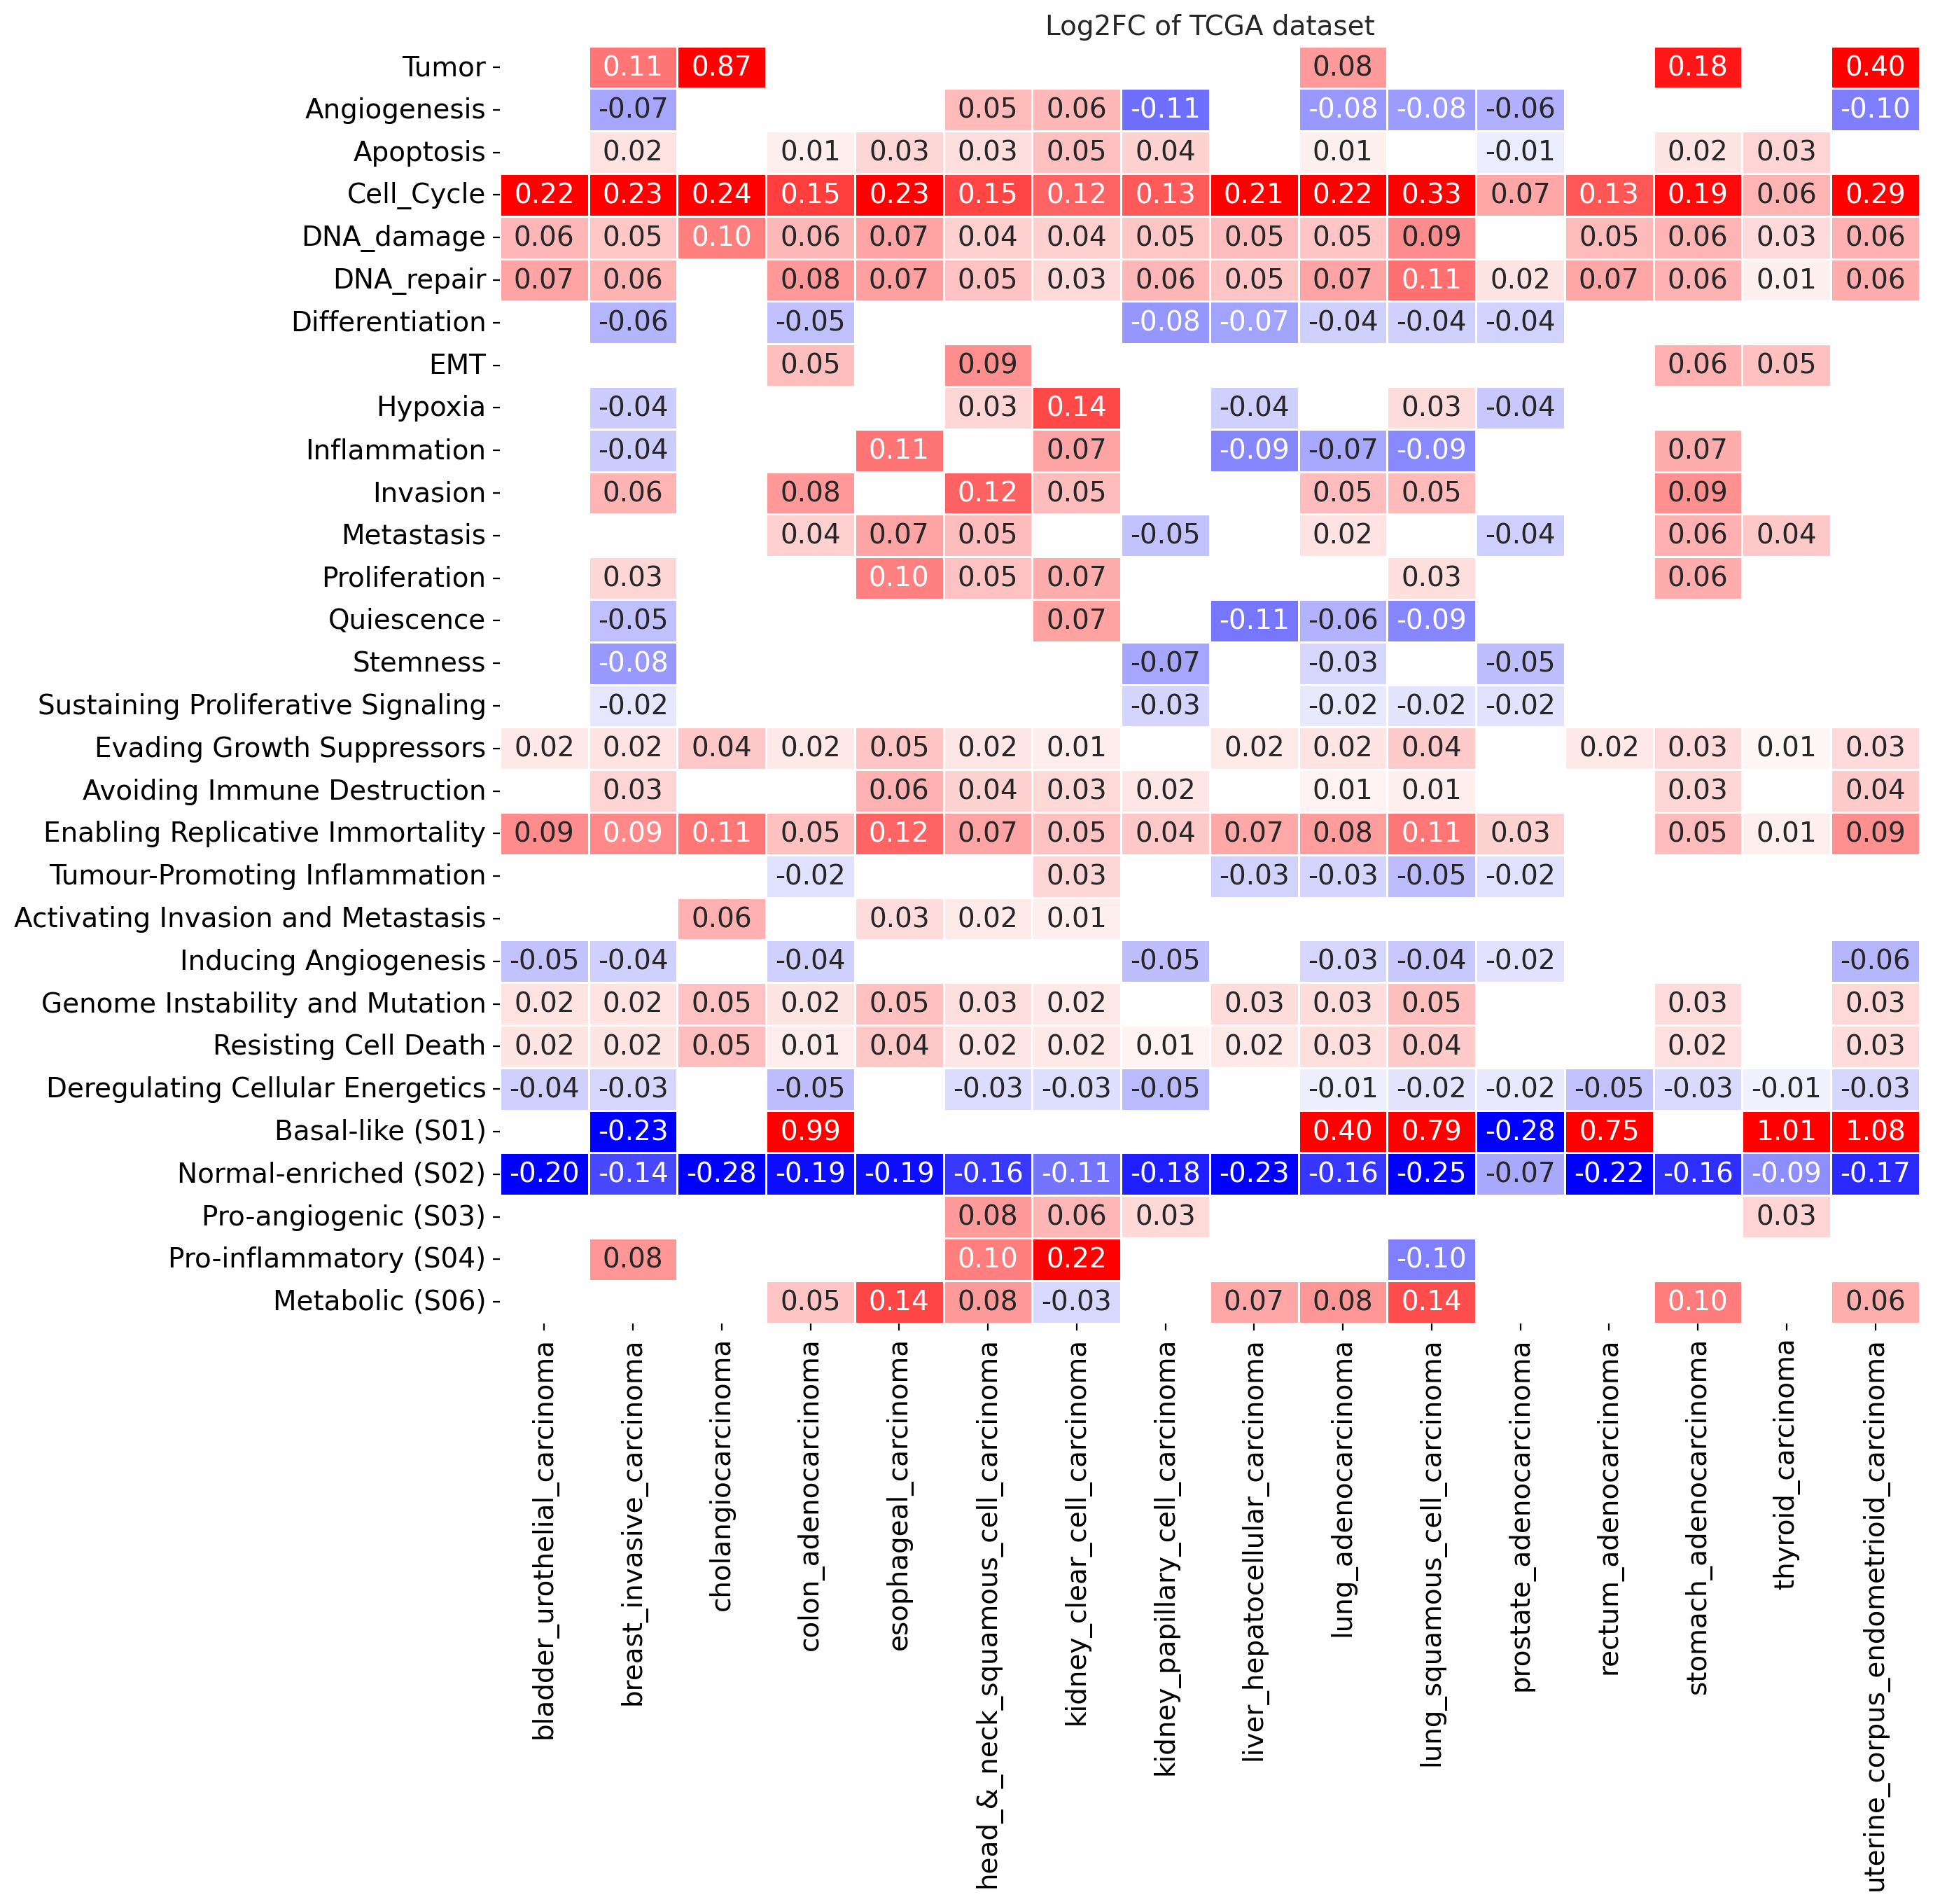

In [41]:
plt.figure(figsize=(13,12))
ax21 = plt.subplot(111)
sns.heatmap(bulk_score_logfc_df.iloc[:,:-2], annot=True, fmt='.2f', cmap='bwr', yticklabels=True, cbar=False, ax=ax21, vmin=-0.2, vmax=0.2, 
            linewidth=1)
_ = ax21.set_title('Log2FC of TCGA dataset')
plt.savefig('./plot/cancer_hallmarks_bulk.heatmap.pdf', bbox_inches='tight')
# _ = plt.xticks(rotation=30)

In [47]:
train_prefixs = ['Lung cancer (LuCA)','Colorectal cancer (Chen et al.)','Colorectal cancer (Lee et al.)',
                 'Gastric cancer (Nowicki-Osuch et al.)','Liver cancer (Ma et al.)']

In [42]:
deg_dict = {}
lc_deg_df = pd.read_csv('./file/deg/training_LC_DEGs.tsv', sep='\t', index_col=0)
crc1_deg_df = pd.read_csv('./file/deg/training_CRC1_DEGs.tsv', sep='\t', index_col=0)
crc2_deg_df = pd.read_csv('./file/deg/training_CRC2_DEGs.tsv', sep='\t', index_col=0)
gc_deg_df = pd.read_csv('./file/deg/training_GC_DEGs.tsv', sep='\t', index_col=0)
hcc_deg_df = pd.read_csv('./file/deg/training_HCC_DEGs.tsv', sep='\t', index_col=0)

In [45]:
cut_logfc = 0.5
cut_pval = 1e-5
cut_pct1 = 0.1
filter_lc_deg_df = lc_deg_df[(lc_deg_df['avg_log2FC']>=cut_logfc) & (lc_deg_df['p_val']<cut_pval) & (lc_deg_df['pct.1']>=cut_pct1)]
filter_crc1_deg_df = crc1_deg_df[(crc1_deg_df['avg_log2FC']>=cut_logfc) & (crc1_deg_df['p_val']<cut_pval) & (crc1_deg_df['pct.1']>=cut_pct1)]
filter_crc2_deg_df = crc2_deg_df[(crc2_deg_df['avg_log2FC']>=cut_logfc) & (crc2_deg_df['p_val']<cut_pval) & (crc2_deg_df['pct.1']>=cut_pct1)]
filter_gc_deg_df = gc_deg_df[(gc_deg_df['avg_log2FC']>=cut_logfc) & (gc_deg_df['p_val']<cut_pval) & (gc_deg_df['pct.1']>=cut_pct1)]
filter_hcc_deg_df = hcc_deg_df[(hcc_deg_df['avg_log2FC']>=cut_logfc) & (hcc_deg_df['p_val']<cut_pval) & (hcc_deg_df['pct.1']>=cut_pct1)]

In [46]:
lung_tumor_degs = filter_lc_deg_df[filter_lc_deg_df['cluster']=='Tumor']['gene'].tolist()
lung_normal_degs = filter_lc_deg_df[filter_lc_deg_df['cluster']=='Normal']['gene'].tolist()
crc_tumor_degs1 = filter_crc1_deg_df[filter_crc1_deg_df['cluster']=='Tumor']['gene'].tolist()
crc_normal_degs1 = filter_crc1_deg_df[filter_crc1_deg_df['cluster']=='Normal']['gene'].tolist()
crc_tumor_degs2 = filter_crc2_deg_df[filter_crc2_deg_df['cluster']=='Tumor']['gene'].tolist()
crc_normal_degs2 = filter_crc2_deg_df[filter_crc2_deg_df['cluster']=='Normal']['gene'].tolist()
gc_tumor_degs = filter_gc_deg_df[filter_gc_deg_df['cluster']=='Tumor']['gene'].tolist()
gc_normal_degs = filter_gc_deg_df[filter_gc_deg_df['cluster']=='Normal']['gene'].tolist()
hcc_tumor_degs = filter_hcc_deg_df[filter_hcc_deg_df['cluster']=='Tumor']['gene'].tolist()
hcc_normal_degs = filter_hcc_deg_df[filter_hcc_deg_df['cluster']=='Normal']['gene'].tolist()

In [49]:
deg_dict = {
    'Upregulated in Lung cancer (LuCA)': lung_tumor_degs, 'Downregulated in Lung cancer (LuCA)': lung_normal_degs, 
    'Upregulated in Colorectal cancer (Chen et al.)': crc_tumor_degs1, 'Downregulated in Colorectal cancer (Chen et al.)': crc_normal_degs1, 
    'Upregulated in Colorectal cancer (Lee et al.)': crc_tumor_degs2, 'Downregulated in Colorectal cancer (Lee et al.)': crc_normal_degs2, 
    'Upregulated in Gastric cancer (Nowicki-Osuch et al.)': gc_tumor_degs, 'Downregulated in Gastric cancer (Nowicki-Osuch et al.)': gc_normal_degs, 
    'Upregulated in Liver cancer (Ma et al.)': hcc_tumor_degs, 'Downregulated in Liver cancer (Ma et al.)': hcc_normal_degs, 
}

In [50]:
deg_count_df = pd.DataFrame(index=deg_dict.keys(), columns=deg_dict.keys())
for a in deg_dict.keys():
    for b in deg_dict.keys():
        deg_count_df.loc[a,b] = len(set(deg_dict[a]) & set(deg_dict[b]))
deg_count_df = deg_count_df.applymap(int)

/tmp/ipykernel_1193/3718517411.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  deg_count_df = deg_count_df.applymap(int)


In [53]:
orders = ['Upregulated in Lung cancer (LuCA)',
          'Upregulated in Colorectal cancer (Chen et al.)',
          'Upregulated in Colorectal cancer (Lee et al.)',
          'Upregulated in Gastric cancer (Nowicki-Osuch et al.)',
          'Upregulated in Liver cancer (Ma et al.)',
          'Downregulated in Lung cancer (LuCA)',
          'Downregulated in Colorectal cancer (Chen et al.)',
          'Downregulated in Colorectal cancer (Lee et al.)',
          'Downregulated in Gastric cancer (Nowicki-Osuch et al.)',
          'Downregulated in Liver cancer (Ma et al.)']

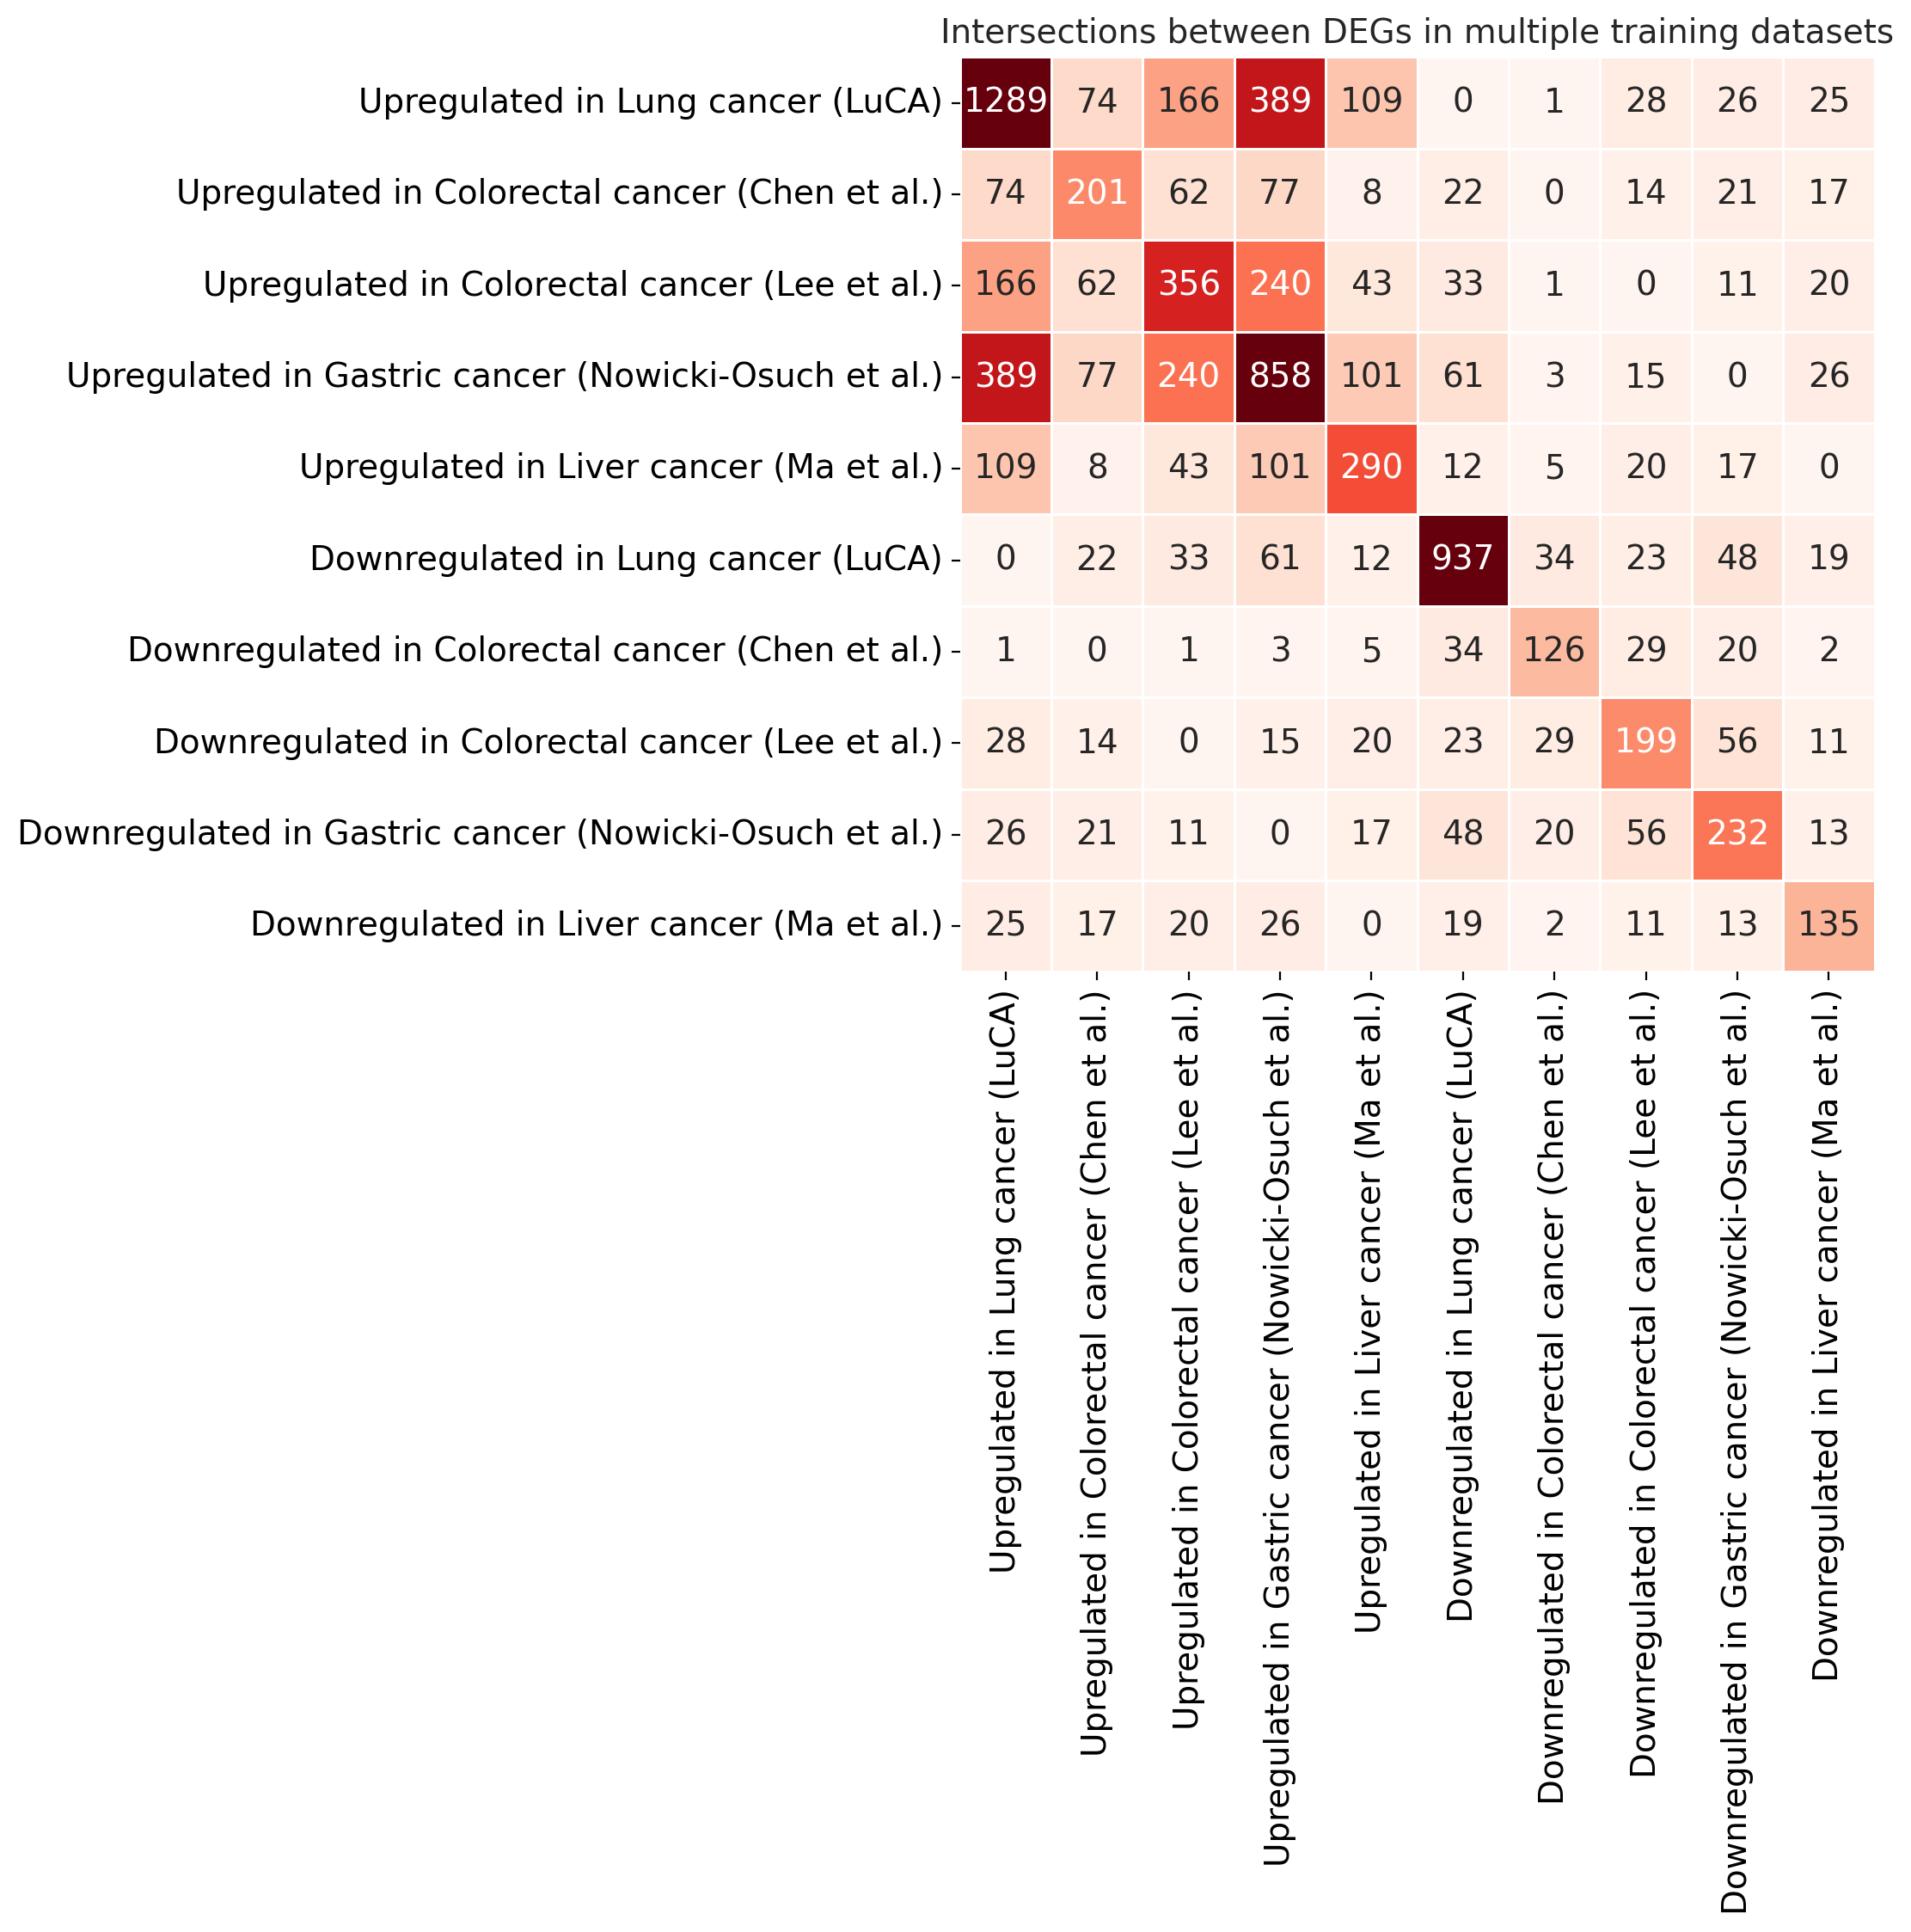

In [57]:
plt.figure(figsize=(7,7))
sns.heatmap(deg_count_df.loc[orders,orders], cmap='Reds', square=True, annot=True, fmt='.0f', vmax=500, linewidth=1, cbar=False)
_ = plt.title('Intersections between DEGs in multiple training datasets')
plt.savefig('./plot/DEG_overlap_training.heatmap.pdf', bbox_inches='tight')

In [59]:
up_count_dict = Counter(lung_tumor_degs+crc_tumor_degs1+crc_tumor_degs2+gc_tumor_degs+hcc_tumor_degs)
down_count_dict = Counter(lung_normal_degs+crc_normal_degs1+crc_normal_degs2+gc_normal_degs+hcc_normal_degs)

In [64]:
len([x for x,y in up_count_dict.items() if y==1]) / len(up_count_dict)

0.6831875607385811

In [65]:
len([x for x,y in down_count_dict.items() if y==1]) / len(down_count_dict)

0.8741159830268741